In [ ]:
 # import libraries and packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# colors

my_colors = ["#c6b34e","#95354a", "#57b9a8","#b0ddff", "#426872","#215c97", "#02b6b4","#b05468","#cd9f62","#aaaaaa","#8fce00","#827861"]
# Create a seaborn palette object
my_palette = sns.color_palette(my_colors)
# Use the custom palette with a seaborn function
sns.set_palette(my_palette)
from matplotlib.colors import ListedColormap
colors = ['#ffffcd', '#ffeaa4', '#ffca2a','#c6b34e']
my_cmap = sns.color_palette(colors)
cmap = ListedColormap(colors)

In [ ]:
# load the dataset and show first 5 rows
df = pd.read_csv('/content/Sentiment Analysis on Student Feedback.csv')
df.head()

,Timestamp,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Unnamed: 11
0,2023/05/21 3:29:49 AM MDT,CPE 321,"The man is too fast in his teaching,he clearly...",No,Male,Regular,Challenging,21 hours,5,Yes,20/30GR072
1,2023/05/21 3:39:59 AM MDT,CPE 331,The class is dry but he really puts in efforts,Yes,Male,Regular,Moderate,7,8,Yes,19/30GR010
2,2023/05/21 3:57:54 AM MDT,CPE 321,The course is shit and it's a threat to my bra...,No,Male,Regular,Challenging,7hrs,4,Yes,20/30GR073
3,2023/05/21 4:52:08 AM MDT,CPE 321,"He no try at all, didn’t teach well.",No,Male,Regular,Challenging,12,1,Yes,NaN
4,2023/05/21 5:24:33 AM MDT,CPE 321,Ogbeni you sef know as e dae go,Yes,Male,Occasional,Difficult,How you want take study something wey you head...,0,Yes,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Timestamp               100 non-null    object
 1   Course Code             100 non-null    object
 2   Feedback                100 non-null    object
 3   Previous Experience     100 non-null    object
 4   Gender                  100 non-null    object
 5   Attendance              100 non-null    object
 6   Course Difficulty       100 non-null    object
 7   Study Hours (per week)  100 non-null    object
 8   Overall Satisfaction    100 non-null    int64 
 9   Department              100 non-null    object
 10  Unnamed: 11             3 non-null      object
dtypes: int64(1), object(10)
memory usage: 8.7+ KB


In [ ]:
df.columns

Index(['Timestamp', 'Course Code', 'Feedback', 'Previous Experience', 'Gender',
       'Attendance', 'Course Difficulty', 'Study Hours (per week)',
       'Overall Satisfaction', 'Department', 'Unnamed: 11'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Timestamp', 'Course Code', 'Feedback', 'Previous Experience', 'Gender',
       'Attendance', 'Course Difficulty', 'Study Hours (per week)',
       'Overall Satisfaction', 'Department', 'Unnamed: 11'],
      dtype='object')


In [ ]:
# drop unncessary column
df = df.drop(['Unnamed: 11'], axis=1)

# Convert the column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract the date and time into separate columns
df['Date'] = df['Timestamp'].dt.date
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = df['Timestamp'].dt.time
df['Hour'] = df['Timestamp'].dt.hour

# drop Timestamp column
df = df.drop(['Timestamp'], axis=1)

# corrections to "Study Hours (per week) column"
df['Study Hours (per week)'] = df['Study Hours (per week)'].str.extract(r'(\d+)').fillna(0).astype(int)


In [ ]:
# overview of the data again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Course Code             100 non-null    object        
 1   Feedback                100 non-null    object        
 2   Previous Experience     100 non-null    object        
 3   Gender                  100 non-null    object        
 4   Attendance              100 non-null    object        
 5   Course Difficulty       100 non-null    object        
 6   Study Hours (per week)  100 non-null    int64         
 7   Overall Satisfaction    100 non-null    int64         
 8   Department              100 non-null    object        
 9   Date                    100 non-null    datetime64[ns]
 10  Time                    100 non-null    object        
 11  Hour                    100 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory us

In [ ]:
# preview random sample of the data
df.sample(5)

,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Hour
34,GSE 301,no stress in this course,No,Female,Occasional,Easy,5,10,Yes,2023-05-29,15:22:05,15
83,CPE 341,love to code and course is about coding. A plu...,Yes,Male,Regular,Easy,18,9,Yes,2023-05-30,14:45:04,14
0,CPE 321,"The man is too fast in his teaching,he clearly...",No,Male,Regular,Challenging,21,5,Yes,2023-05-21,03:29:49,3
27,CPE 321,We are basically left to go study that course ...,No,Female,Regular,Difficult,8,2,Yes,2023-05-26,14:45:34,14
66,MEE 361,Applied my math's knowledge from 200L for the ...,Yes,Female,Irregular,Moderate,18,6,Yes,2023-05-30,14:18:31,14


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # Add this line to download the wordnet resource

# Import necessary modules (re, string, and others)

def preprocess_text(text):
    """
    Preprocess a text string for sentiment analysis.

    Parameters
    ----------
    text : str
        The text string to preprocess.

    Returns
    -------
    str
        The preprocessed text string.
    """

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, hashtags, mentions, and special characters
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # Remove numbers/digits
    text = re.sub(r'\b[0-9]+\b\s*', '', text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    return ' '.join(tokens)

# Assuming df is your DataFrame, and 'Feedback' is the column containing text data
df['Processed_Feedback'] = df['Feedback'].apply(preprocess_text)
df.tail(10)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Hour,Processed_Feedback
90,CPE 341,love to code,Yes,Female,Regular,Moderate,7,7,Yes,2023-05-30,14:50:42,14,love code
91,CPE 381,practicals were okay for me sha,No,Female,Regular,Easy,12,8,Yes,2023-05-30,14:52:57,14,practicals okay sha
92,MEE 361,nice,Yes,Female,Regular,Easy,15,9,Yes,2023-05-30,14:53:35,14,nice
93,GSE 301,GSE was very okay,Yes,Female,Irregular,Easy,5,9,Yes,2023-05-30,14:54:23,14,gse okay
94,CPE 311,nice course,Yes,Male,Regular,Easy,10,9,Yes,2023-05-30,14:55:21,14,nice course
95,GSE 301,easy and no wahala,Yes,Female,Regular,Easy,9,8,Yes,2023-05-30,14:56:07,14,easy wahala
96,CPE 321,terrible way of teaching with the I-dont-care ...,No,Female,Irregular,Difficult,4,0,Yes,2023-05-30,14:57:17,14,terrible way teaching idontcare attitude
97,CPE 341,do not like coding,No,Male,Irregular,Difficult,0,0,Yes,2023-05-30,15:02:16,15,like coding
98,CPE 381,this practical is hard on top 1 unit course haba,No,Female,Regular,Difficult,5,0,Yes,2023-05-30,15:03:39,15,practical hard top unit course haba
99,CPE 321,"not the right way to teach, Mr Akanni",No,Male,Occasional,Difficult,3,0,Yes,2023-05-30,15:05:02,15,right way teach mr akanni


In [ ]:
# lets check out the new processed text column
df['Processed_Feedback'][:10].to_frame()

,Processed_Feedback
0,man fast teachinghe clearly doesnt know teach ...
1,class dry really put effort
2,course shit threat brainthe teaching mode poor
3,try didnt teach well
4,ogbeni sef know e dae go
5,omo god judge ak sha dont take class like expe...
6,man good
7,e choke
8,teaching mode okay lecturer revision whats tau...
9,basically experience cpe isnt hard method empl...


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=131958ac1b5e5223591d0ca52d675a00894d1f9fec1a6c0208d7bea8bf84cb2a
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return None

df['Language'] = df['Processed_Feedback'].apply(detect_language)

In [ ]:
df['Language'].unique()

array(['en', 'cy', 'so', 'sk', 'af', 'fr', 'hr', 'id', 'pt', 'pl', 'tr',
       'es', 'tl'], dtype=object)

In [ ]:
language_mapping = {
    'en': 'English',
    'cy': 'Welsh',
    'so': 'Somali',
    'sk': 'Slovak',
    'af': 'Afrikaans',
    'fr': 'French',
    'hr': 'Croatian',
    'id': 'Indonesian',
    'pt': 'Portuguese',
    'it': 'Italian',
    'pl': 'Polish',
    'es': 'Spanish'
}

df['Language'] = df['Language'].map(language_mapping)
df['Language'].unique()

array(['English', 'Welsh', 'Somali', 'Slovak', 'Afrikaans', 'French',
       'Croatian', 'Indonesian', 'Portuguese', 'Polish', nan, 'Spanish'],
      dtype=object)

In [ ]:
df

,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Hour,Processed_Feedback,Language
0,CPE 321,"The man is too fast in his teaching,he clearly...",No,Male,Regular,Challenging,21,5,Yes,2023-05-21,03:29:49,3,man fast teachinghe clearly doesnt know teach ...,English
1,CPE 331,The class is dry but he really puts in efforts,Yes,Male,Regular,Moderate,7,8,Yes,2023-05-21,03:39:59,3,class dry really put effort,English
2,CPE 321,The course is shit and it's a threat to my bra...,No,Male,Regular,Challenging,7,4,Yes,2023-05-21,03:57:54,3,course shit threat brainthe teaching mode poor,English
3,CPE 321,"He no try at all, didn’t teach well.",No,Male,Regular,Challenging,12,1,Yes,2023-05-21,04:52:08,4,try didnt teach well,English
4,CPE 321,Ogbeni you sef know as e dae go,Yes,Male,Occasional,Difficult,0,0,Yes,2023-05-21,05:24:33,5,ogbeni sef know e dae go,Welsh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,GSE 301,easy and no wahala,Yes,Female,Regular,Easy,9,8,Yes,2023-05-30,14:56:07,14,easy wahala,Somali
96,CPE 321,terrible way of teaching with the I-dont-care ...,No,Female,Irregular,Difficult,4,0,Yes,2023-05-30,14:57:17,14,terrible way teaching idontcare attitude,English
97,CPE 341,do not like coding,No,Male,Irregular,Difficult,0,0,Yes,2023-05-30,15:02:16,15,like coding,Croatian
98,CPE 381,this practical is hard on top 1 unit course haba,No,Female,Regular,Difficult,5,0,Yes,2023-05-30,15:03:39,15,practical hard top unit course haba,English


In [ ]:
df['Char_Count'] = df['Processed_Feedback'].apply(len) # can also use df['Processed_Feedback'].str.len()
df['Word_Count'] = df['Processed_Feedback'].apply(lambda x: len(x.split()))
df = df.drop(['Language'], axis=1)
df.sort_values(by='Char_Count', ascending=False).head(10)

,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Hour,Processed_Feedback,Char_Count,Word_Count
43,CPE 341,The teaching mode and environment is top tier ...,No,Male,Regular,Challenging,6,5,Yes,2023-05-29,15:44:32,15,teaching mode environment top tier course requ...,201,26
9,CPE 321,"Basically from my own experience, CPE 321 isn’...",No,Male,Regular,Challenging,5,3,Yes,2023-05-21,09:44:44,9,basically experience cpe isnt hard method empl...,146,21
17,CPE 331,The course is actually well detailed in the ma...,No,Male,Regular,Easy,10,7,Yes,2023-05-24,09:29:41,9,course actually well detailed material lecture...,117,16
20,MEE 361,This lecturer really tried for us to be honest...,Yes,Male,Regular,Moderate,12,7,Yes,2023-05-24,09:35:13,9,lecturer really tried u honest teaching hundre...,98,15
5,CPE 321,"Omo, God will judge AK sha.\nYou don’t take a ...",No,Male,Regular,Difficult,9,1,Yes,2023-05-21,05:31:57,5,omo god judge ak sha dont take class like expe...,97,18
11,CPE 321,The course is very very difficult and the lect...,No,Male,Regular,Difficult,6,0,Yes,2023-05-21,18:57:34,18,course difficult lecturer dey even make easy a...,96,14
24,CPE 321,I felt the course was a bit rushed in terms of...,No,Male,Regular,Challenging,4,1,Yes,2023-05-24,16:39:40,16,felt course bit rushed term teaching course al...,85,13
13,CPE 321,The course isn’t supposed to be this difficult...,Yes,Male,Regular,Challenging,0,2,Yes,2023-05-22,02:42:44,2,course isnt supposed difficult lecturer taken ...,85,12
16,CPE 321,The lecturer is fucking terrible. With his I-d...,No,Male,Regular,Difficult,7,0,Yes,2023-05-24,09:27:51,9,lecturer fucking terrible idontcare attitude t...,79,10
15,CPE 311,The lecturer is cool and calm. Her teaching me...,Yes,Male,Regular,Easy,9,9,Yes,2023-05-24,09:26:26,9,lecturer cool calm teaching method make easier...,64,9


count    100.000000
mean       0.049889
std        0.494125
min       -1.000000
25%       -0.028125
50%        0.000000
75%        0.433333
max        1.000000
Name: Sentiment_Scores, dtype: float64


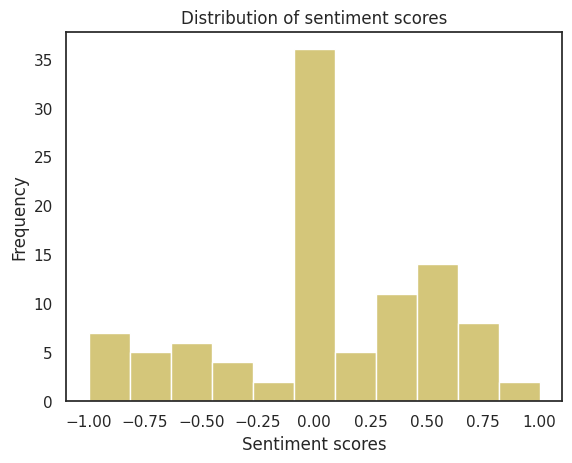

In [ ]:
# Calculate sentiment scores
df['Sentiment_Scores'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

print(df['Sentiment_Scores'].describe())

sns.histplot(df['Sentiment_Scores'])
plt.title('Distribution of sentiment scores')
plt.ylabel('Frequency')
plt.xlabel('Sentiment scores')
plt.show()

In [ ]:
def sentiment_analyzer(score):
    """
    Classify sentiment based on a score.

    Parameters
    ----------
    score : float
        The sentiment score to classify.

    Returns
    -------
    str
        The sentiment label.
    """

    if score > 0.049889:
        return 'positive'

    elif score < 0.049889:
        return 'negative'

    else:
        return 'neutral'


# Assuming you have a DataFrame named 'df' with a column 'Sentiment_Scores'
df['Sentiments'] = df['Sentiment_Scores'].apply(sentiment_analyzer)

In [ ]:
print(list(df['Sentiment_Scores']))

df['Sentiments'].value_counts()

[0.15000000000000002, 0.06666666666666668, -0.30000000000000004, 0.0, 0.0, -0.5, 0.7, 0.0, 0.5, 0.20277777777777775, 0.0, -0.022222222222222216, 0.0, -0.5, 0.0, 0.325, -0.6333333333333333, -0.19999999999999998, -1.0, 0.0, 0.26666666666666666, 0.4000000000000001, -1.0, -1.0, -0.3, 0.0062500000000000056, 0.7, 0.0, 0.0, -0.2916666666666667, 0.7, 0.0, 0.0, 0.0, 0.0, 0.7, -0.7999999999999999, 0.6, -0.04583333333333334, 0.0, 0.43333333333333335, 0.0, -1.0, 0.044642857142857144, 0.6, -1.0, 0.43333333333333335, -0.5999999999999999, 0.27777777777777773, -0.8, 0.0, -0.13333333333333325, 0.0, -0.2916666666666667, 0.35, 0.0, 0.39444444444444443, 0.0, 0.0, 0.0, 0.0, 0.43333333333333335, -1.0, 0.6, 0.0, 0.0, 0.0, 0.7, 0.35, -0.5999999999999999, 0.6, 0.0, 0.0, 0.5166666666666666, 0.8, -0.8, 0.6, 0.0, -0.6999999999999998, 0.7, 0.7, -0.5, 0.22727272727272727, 0.5, -0.6944444444444444, 0.6, 0.0, 1.0, 0.0, 1.0, 0.5, 0.5, 0.6, 0.5, 0.6, 0.43333333333333335, -1.0, 0.0, 0.10416666666666666, 0.28571428571428

negative    59
positive    41
Name: Sentiments, dtype: int64

In [ ]:
# Sentiment Analysis Metrics
sentiment_counts = df['Sentiments'].value_counts()

# Descriptive Statistics
study_hours_stats = df['Study Hours (per week)'].describe()
overall_satisfaction_stats = df['Overall Satisfaction'].describe()

# Categorical Metrics
course_code_counts = df['Course Code'].value_counts()
department_counts = df['Department'].value_counts()
sentiment_distribution = df.groupby('Course Code')['Sentiments'].value_counts(normalize=True)

# Print the calculated metrics
print("Sentiment Analysis Metrics:")
print(sentiment_counts)
print("\nDescriptive Statistics - Study Hours:")
print(study_hours_stats)
print("\nDescriptive Statistics - Overall Satisfaction:")
print(overall_satisfaction_stats)
print("\nCategorical Metrics - Course Code Counts:")
print(course_code_counts)
print("\nCategorical Metrics - Department Counts:")
print(department_counts)
print("\nSentiment Distribution by Course Code:")
print(sentiment_distribution)

Sentiment Analysis Metrics:
negative    59
positive    41
Name: Sentiments, dtype: int64

Descriptive Statistics - Study Hours:
count    100.000000
mean       8.310000
std        5.506094
min        0.000000
25%        4.000000
50%        8.000000
75%       12.000000
max       21.000000
Name: Study Hours (per week), dtype: float64

Descriptive Statistics - Overall Satisfaction:
count    100.000000
mean       5.100000
std        3.599944
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max       10.000000
Name: Overall Satisfaction, dtype: float64

Categorical Metrics - Course Code Counts:
CPE 321    31
CPE 311    13
CPE 341    13
CPE 381    12
CPE 331    11
MEE 361    10
GSE 301    10
Name: Course Code, dtype: int64

Categorical Metrics - Department Counts:
Yes    99
No      1
Name: Department, dtype: int64

Sentiment Distribution by Course Code:
Course Code  Sentiments
CPE 311      positive      0.846154
             negative      0.153846
CPE 321      n

In [ ]:
# analyze the frequency of specific keywords or phrases in the feedback
from collections import Counter

# The keywords or phrases of interest
keywords = ['shit', 'difficult', 'terrible', 'okay', 'best', 'worst', 'good', 'try', 'bad']

# Concatenate all the preprocessed feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

# Tokenize the text into individual words
tokens = all_feedback.split()

# Count the frequency of each keyword in the feedback
keyword_frequency = Counter(tokens)

# Print the frequency of each keyword
for keyword in keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")

Frequency of 'shit': 1
Frequency of 'difficult': 4
Frequency of 'terrible': 5
Frequency of 'okay': 3
Frequency of 'best': 3
Frequency of 'worst': 2
Frequency of 'good': 8
Frequency of 'try': 1
Frequency of 'bad': 4


In [ ]:
# analyze the frequency of specific keywords or phrases in the feedback

negative_keywords = [
    'shit',
    'difficult',
    'terrible',
    'okay',
    'worst',
    'bad',
    'try',
    'boring',
    'confusing',
    'disappointed',
    'discouraged',
    'dumb',
    'frustrated',
    'horrible',
    'lame',
    'lousy',
    'miserable',
    'pointless',
    'stupid',
    'useless'
]

positive_keywords = [
    'amazing',
    'awesome',
    'brilliant',
    'clear',
    'clever',
    'creative',
    'helpful',
    'inspiring',
    'interesting',
    'intelligent',
    'lovely',
    'nice',
    'outstanding',
    'perfect',
    'wonderful'
]

# Concatenate all the feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

# Tokenize the text into individual words
tokens = nltk.word_tokenize(all_feedback)

# Filter out stop words
stop_words = nltk.corpus.stopwords.words('english')
filtered_tokens = [token for token in tokens if token not in stop_words]

# Create a dictionary to store the frequency of each keyword
keyword_frequency = Counter(filtered_tokens)

# Print the frequency of each keyword
for keyword in negative_keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")

for keyword in positive_keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")

Frequency of 'shit': 1
Frequency of 'difficult': 4
Frequency of 'terrible': 5
Frequency of 'okay': 3
Frequency of 'worst': 2
Frequency of 'bad': 4
Frequency of 'try': 1
Frequency of 'boring': 1
Frequency of 'confusing': 0
Frequency of 'disappointed': 0
Frequency of 'discouraged': 0
Frequency of 'dumb': 0
Frequency of 'frustrated': 0
Frequency of 'horrible': 0
Frequency of 'lame': 0
Frequency of 'lousy': 0
Frequency of 'miserable': 0
Frequency of 'pointless': 0
Frequency of 'stupid': 1
Frequency of 'useless': 0
Frequency of 'amazing': 0
Frequency of 'awesome': 1
Frequency of 'brilliant': 0
Frequency of 'clear': 0
Frequency of 'clever': 0
Frequency of 'creative': 0
Frequency of 'helpful': 0
Frequency of 'inspiring': 0
Frequency of 'interesting': 0
Frequency of 'intelligent': 0
Frequency of 'lovely': 0
Frequency of 'nice': 9
Frequency of 'outstanding': 0
Frequency of 'perfect': 0
Frequency of 'wonderful': 0


In [ ]:
# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform LDA topic modeling
num_topics = 10  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()  # Use get_feature_names_out() instead
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()


Topic 0:
course lecturer difficult lecturer difficult hard time isnt teaching course difficult man

Topic 1:
course good lecturer nice terrible nice course easy course easy awful lecturer good

Topic 2:
course nice teaching lecturer method teaching method stress method lecturer nice teaching cool

Topic 3:
teaching code terrible course method teaching method bad love love code course taught

Topic 4:
time bad okay teaching teaching mode mode taught lecturer revision revision whats

Topic 5:
course make class dey especially dey make experience easy man pas

Topic 6:
akanni cool way god teach know really dry class dry know teach

Topic 7:
course easy awful wahala course hard hard good lecturer unit course unit

Topic 8:
lecturer course class course lecturer hate man wey plus lecturer good dey

Topic 9:
course lecturer god class student sha teaching coding like understand



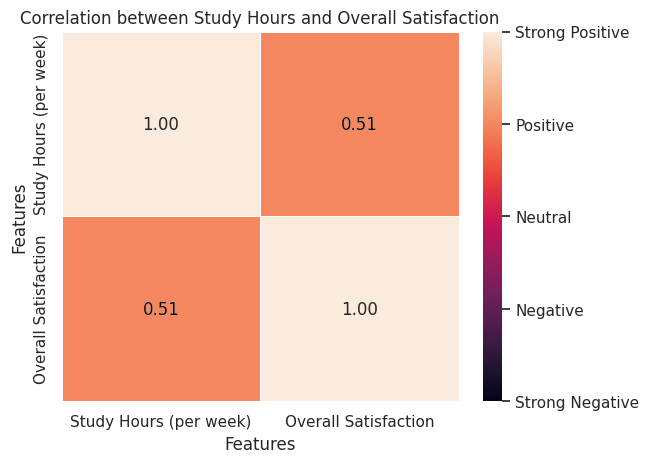

In [ ]:
correlation_matrix = df[['Study Hours (per week)', 'Overall Satisfaction']].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Study Hours and Overall Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

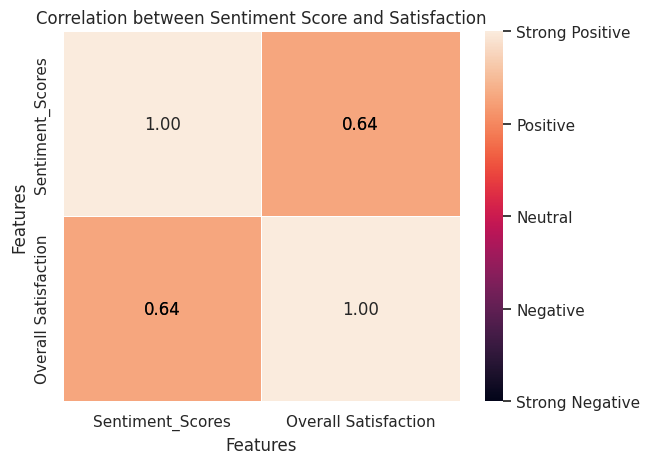

In [ ]:
correlation_matrix = df[['Sentiment_Scores', 'Overall Satisfaction']].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Sentiment Score and Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

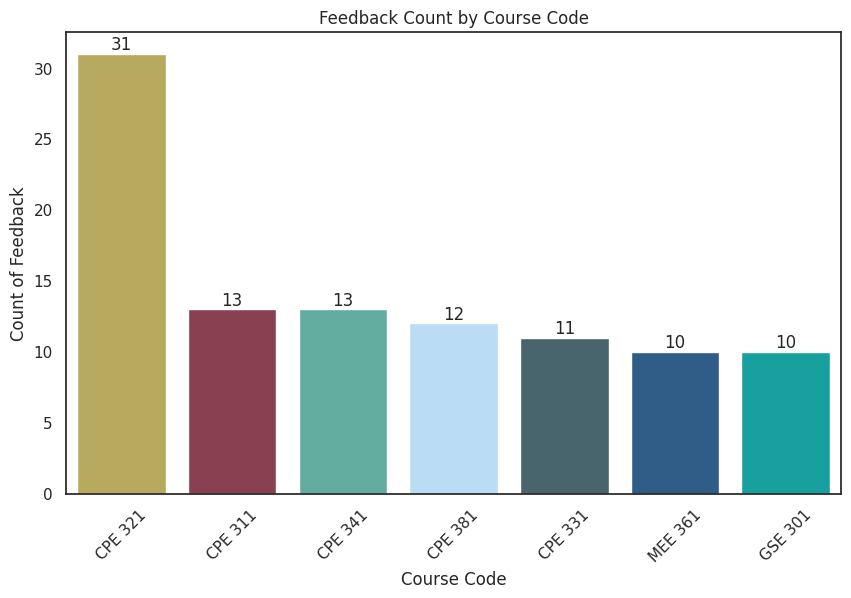

In [ ]:
# Bar plot for Course Code
plt.figure(figsize=(10, 6))
order = df['Course Code'].value_counts().index
ax = sns.countplot(data=df, x='Course Code', order=order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Code')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

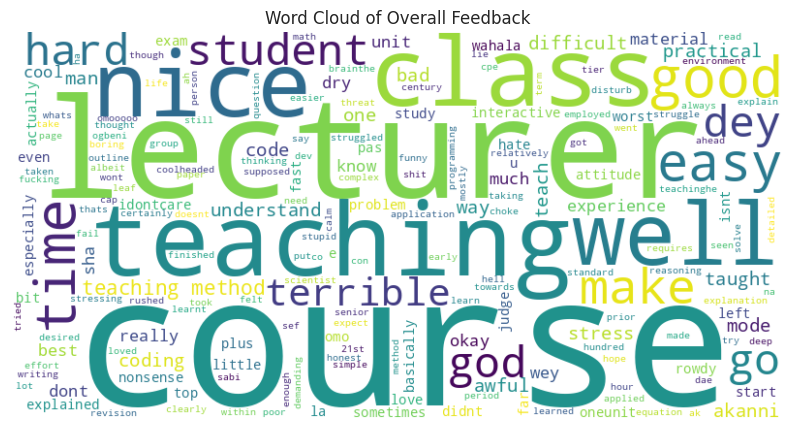

In [ ]:
# Word cloud for Overall Feedback: Combine all feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Overall Feedback')
plt.show()


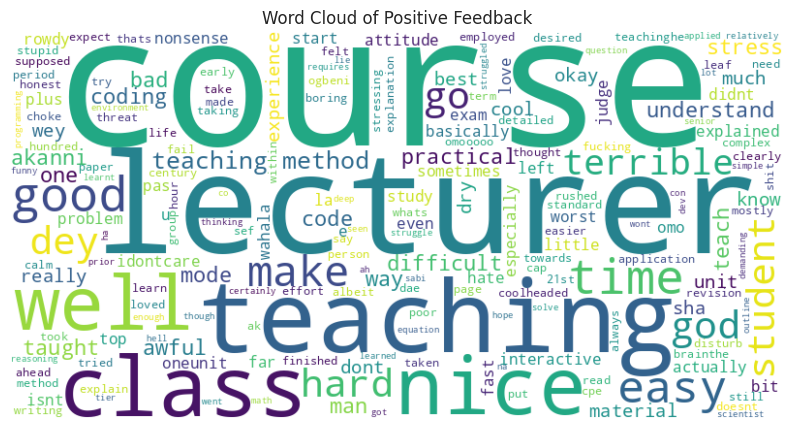

In [ ]:
# Word cloud for Positive Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'positive']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Feedback')
plt.show()

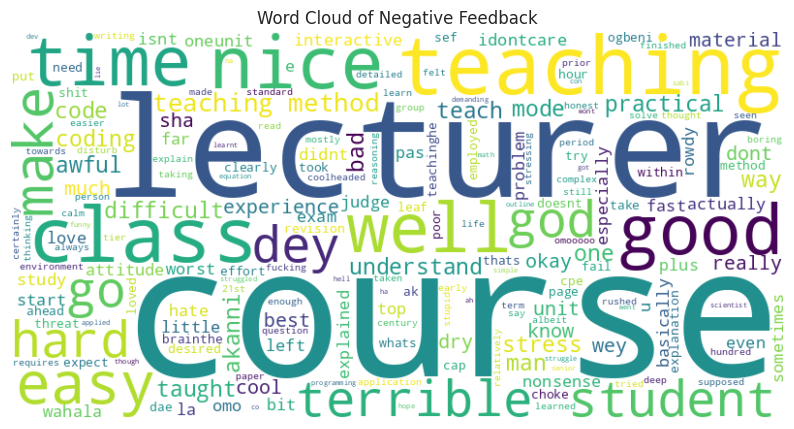

In [ ]:
# Word cloud for Negative Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'negative']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Feedback')
plt.show()

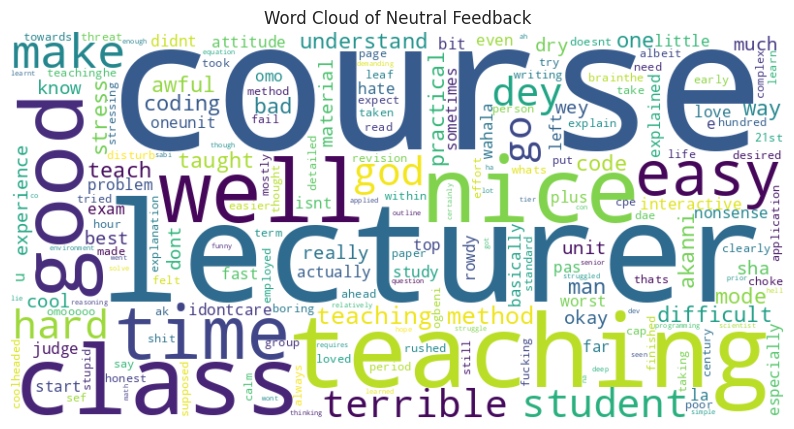

In [ ]:
# Word cloud for Neutral Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'neutral']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Feedback')
plt.show()

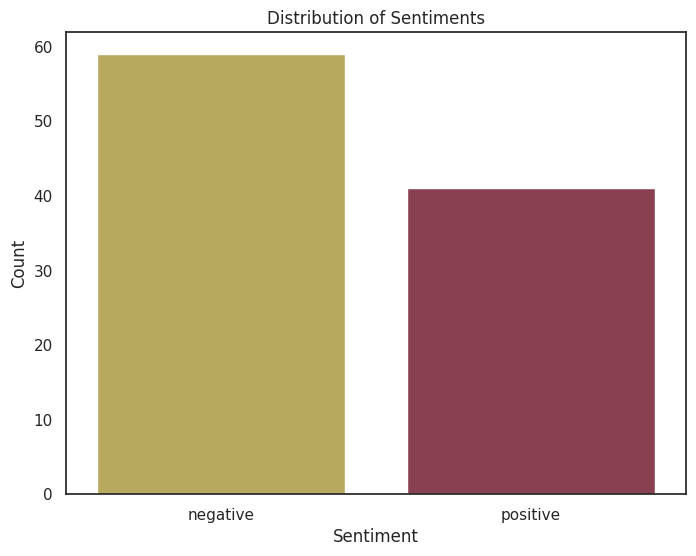

In [ ]:
# Bar plot for Sentiment
plt.figure(figsize=(8, 6))
order = df['Sentiments'].value_counts().index
ax = sns.countplot(data=df, x='Sentiments', order=order)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()

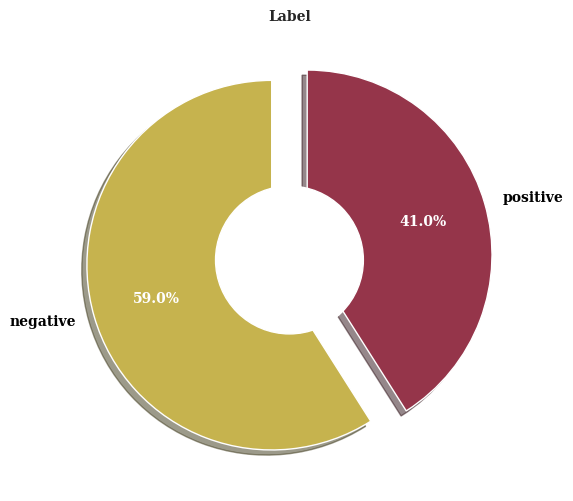

In [ ]:
label_data = df['Sentiments'].value_counts()
# explode = (0.1, 0.1, 0.1)
explode = (0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,labels = label_data.index,pctdistance = 0.65,shadow = True,startangle = 90,explode = explode,
                               autopct = '%1.1f%%',textprops={ 'fontsize': 10,'color': 'black','weight': 'bold','family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

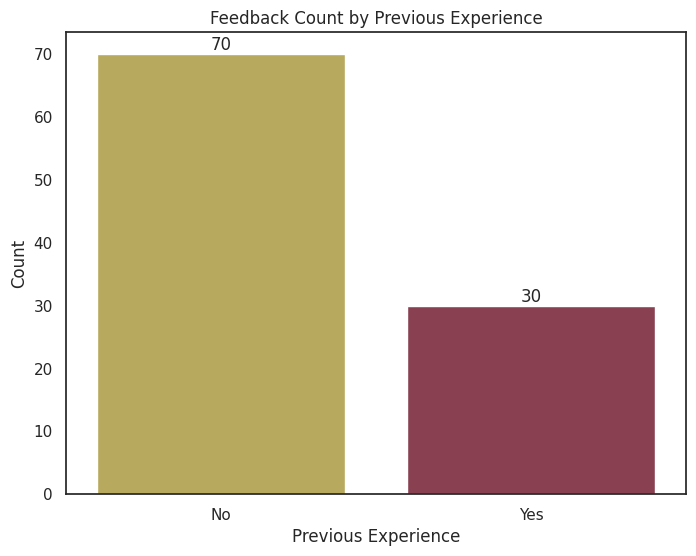

In [ ]:
# Bar plot for Previous Experience
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Previous Experience')
plt.xlabel('Previous Experience')
plt.ylabel('Count')
plt.title('Feedback Count by Previous Experience')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

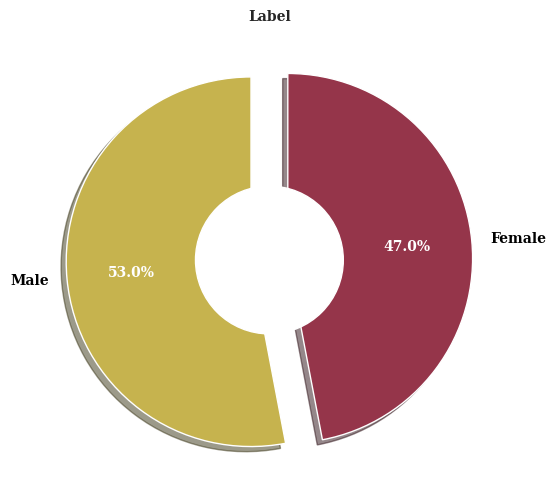

In [ ]:
label_data = df['Gender'].value_counts()
explode = (0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,labels = label_data.index,pctdistance = 0.65,shadow = True,startangle = 90,explode = explode,
                               autopct = '%1.1f%%',textprops={ 'fontsize': 10,'color': 'black','weight': 'bold','family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

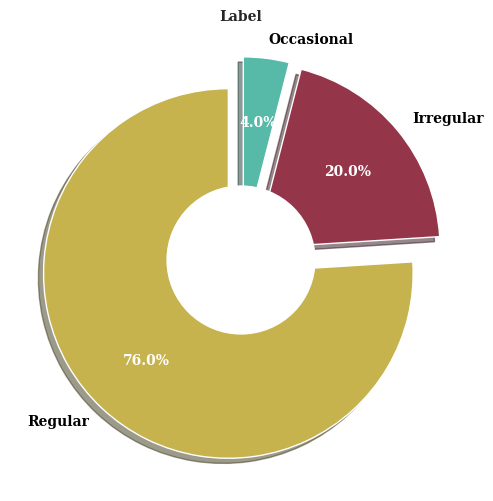

In [ ]:
label_data = df['Attendance'].value_counts()
explode = (0.1, 0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,labels = label_data.index,pctdistance = 0.65,shadow = True,startangle = 90,explode = explode,
                               autopct = '%1.1f%%',textprops={ 'fontsize': 10,'color': 'black','weight': 'bold','family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

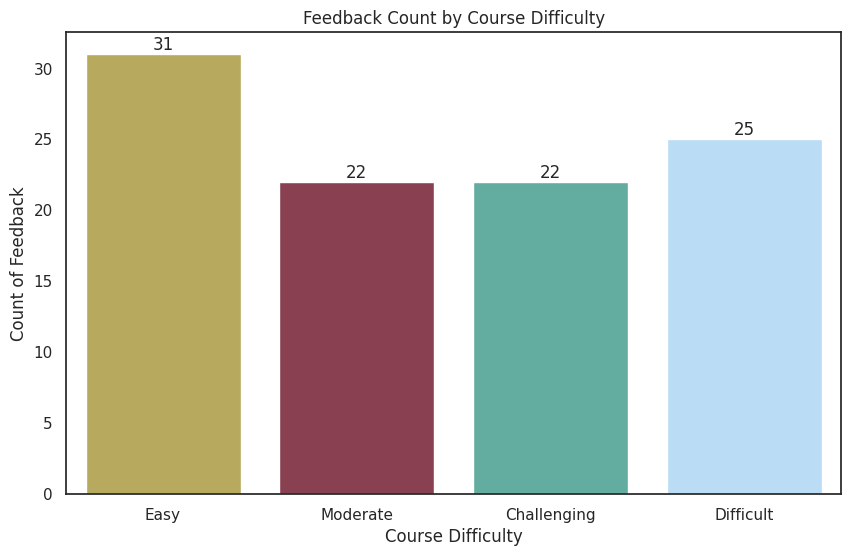

In [ ]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
ax = sns.countplot(data=df, x='Course Difficulty', order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show();

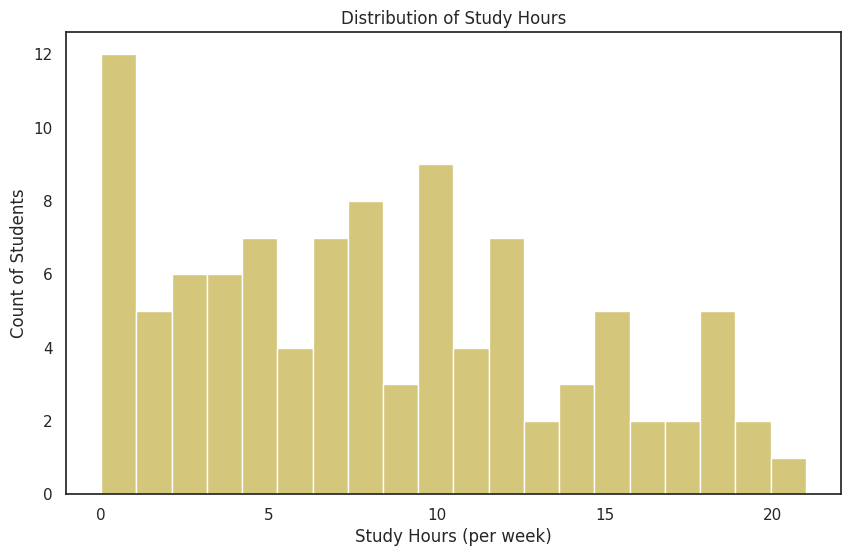

In [ ]:
# Histogram for Study Hours (per week)
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='Study Hours (per week)', bins=20)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Count of Students')
plt.title('Distribution of Study Hours')
plt.show()

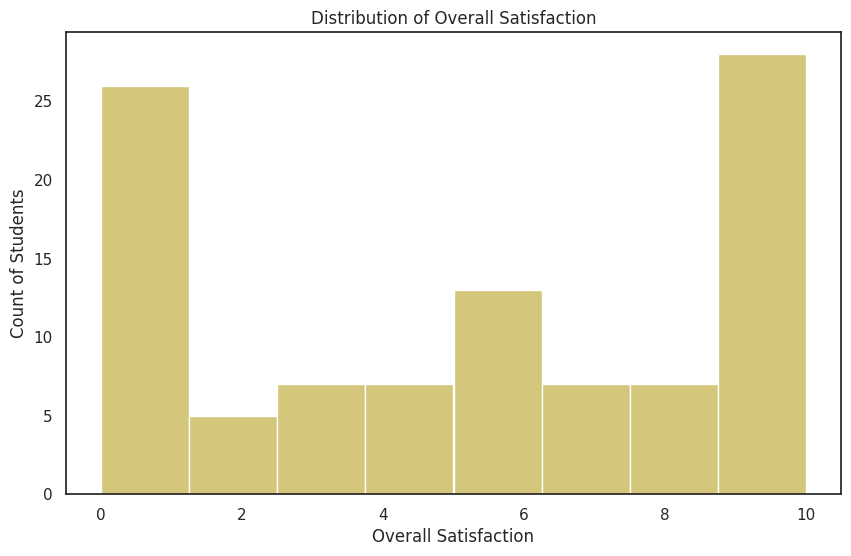

In [ ]:
# Histogram for Overall Satisfaction
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Overall Satisfaction')
plt.xlabel('Overall Satisfaction')
plt.ylabel('Count of Students')
plt.title('Distribution of Overall Satisfaction')
plt.show()

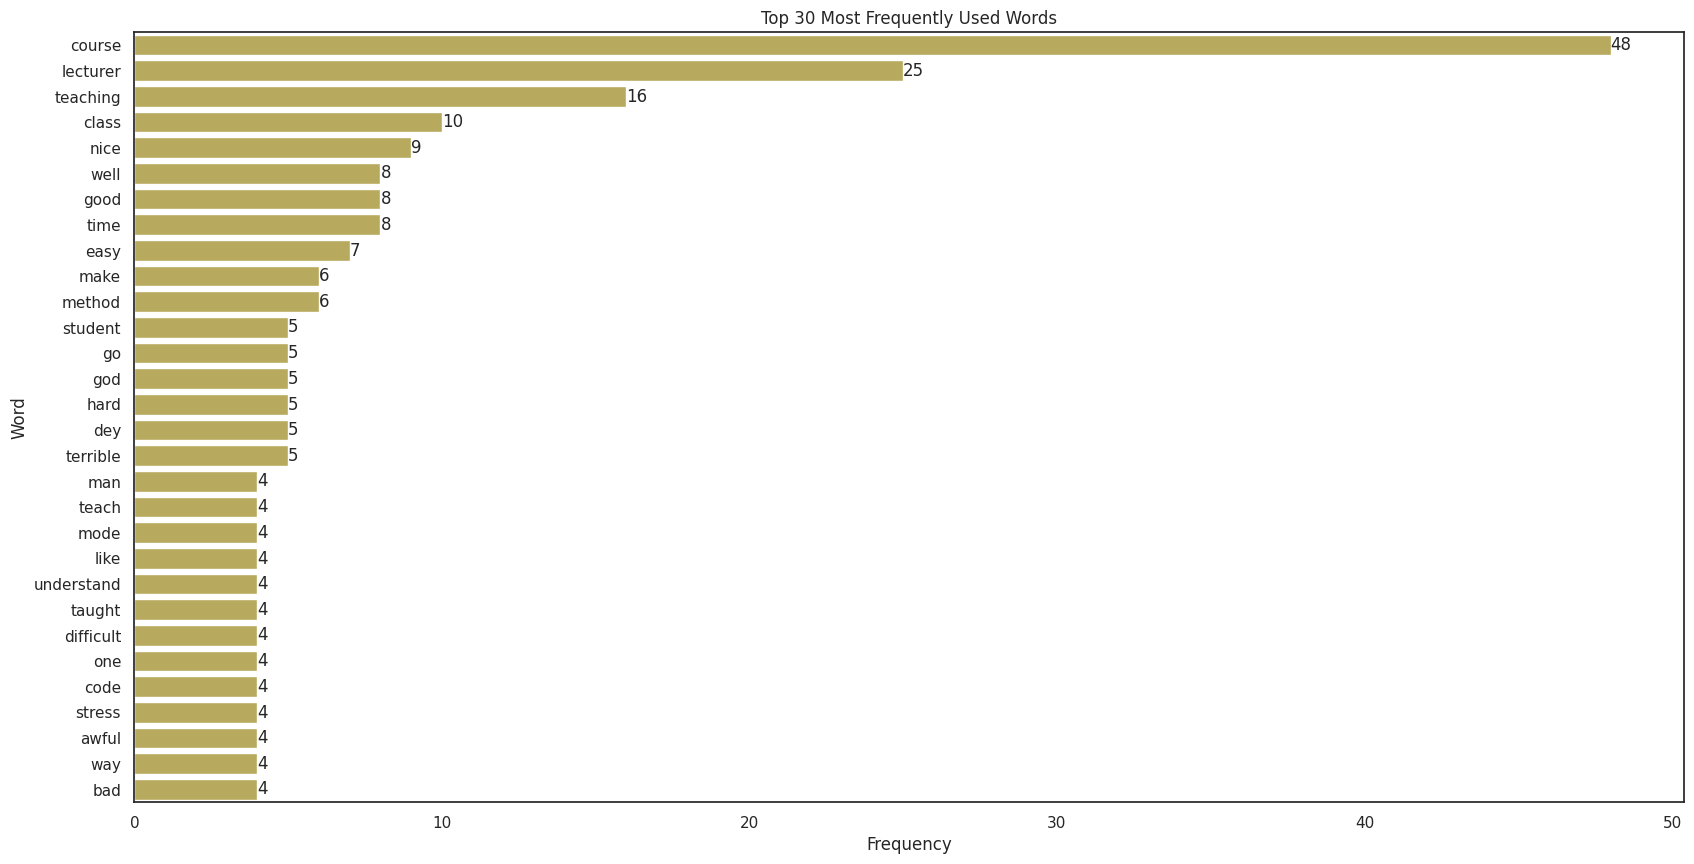

In [ ]:
# Word Frequency Analysis
from collections import Counter
word_frequency = Counter(" ".join(df['Processed_Feedback']).split()).most_common(30)
plt.figure(figsize=(20, 10))
color = sns.color_palette()[0]
ax = sns.barplot(x=[word[1] for word in word_frequency], y=[word[0] for word in word_frequency], color=color)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 30 Most Frequently Used Words')
plt.show()


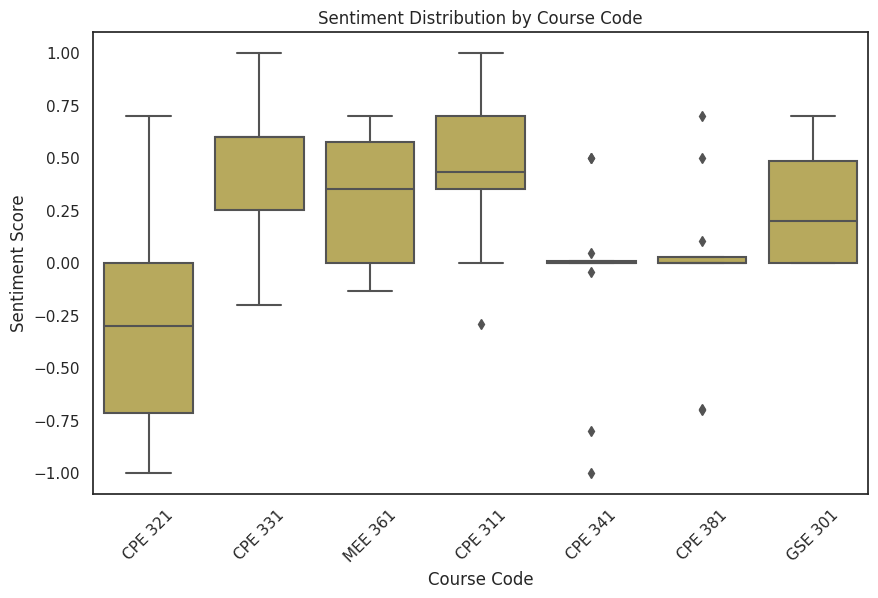

In [ ]:
# Sentiment Box Plots
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Code', y='Sentiment_Scores', color=color)
plt.xlabel('Course Code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution by Course Code')
plt.xticks(rotation=45)
plt.show()

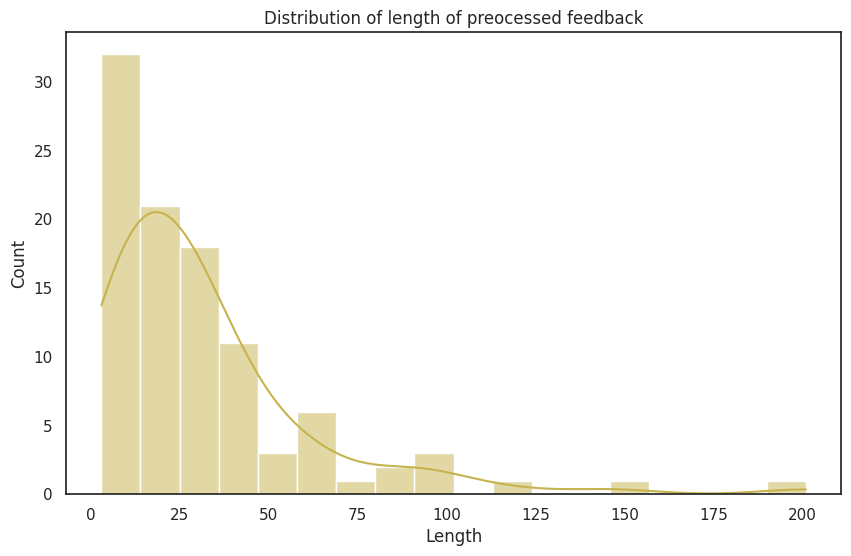

In [ ]:
# Distribution of length of preocessed feedback
plt.figure(figsize=(10, 6))
sns.histplot(df['Char_Count'], kde = True, palette = 'hls')
plt.title('Distribution of length of preocessed feedback')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

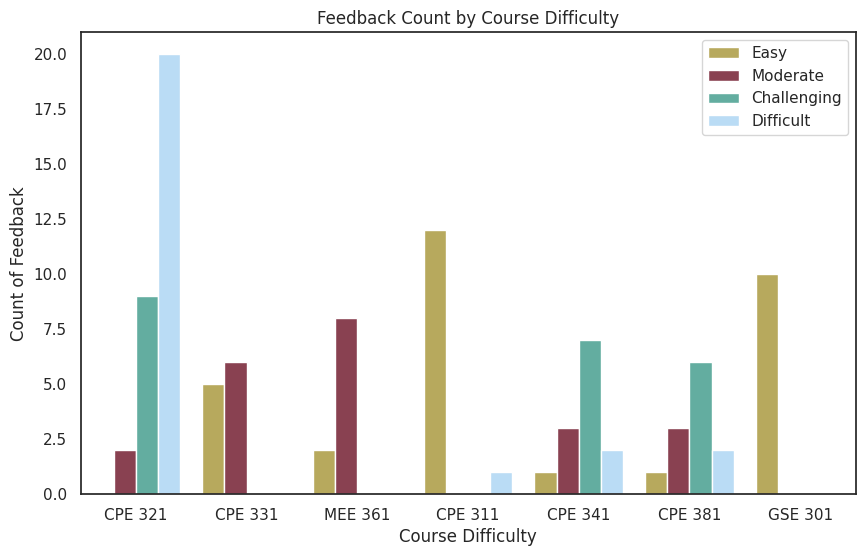

In [ ]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Code', hue='Course Difficulty', hue_order=hue_order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
plt.legend(loc=1)
plt.show();

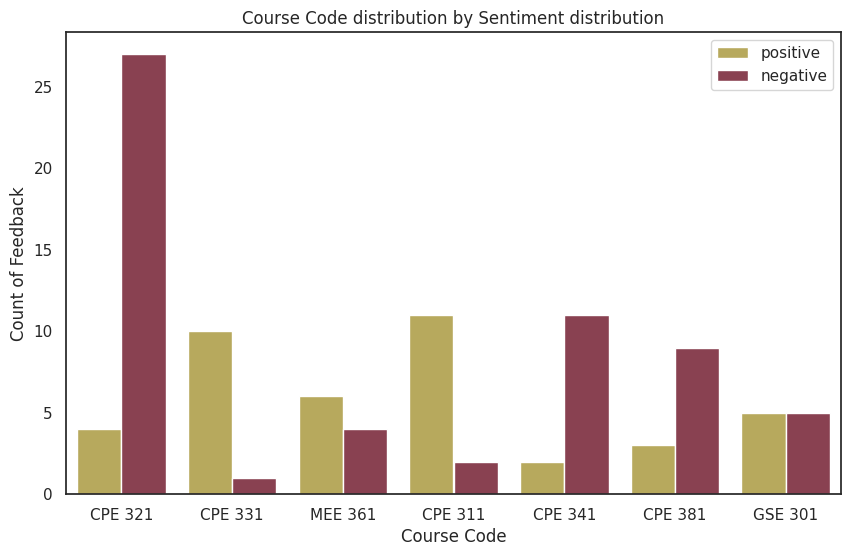

In [ ]:
# Bar plot for Course Code distribution by Sentiment distribution
plt.figure(figsize=(10, 6))
# hue_order = ['positive', 'neutral', 'negative']
hue_order = ['positive', 'negative']
sns.countplot(data=df, x='Course Code', hue='Sentiments', hue_order=hue_order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Course Code distribution by Sentiment distribution')
plt.legend(loc=1)
plt.show();

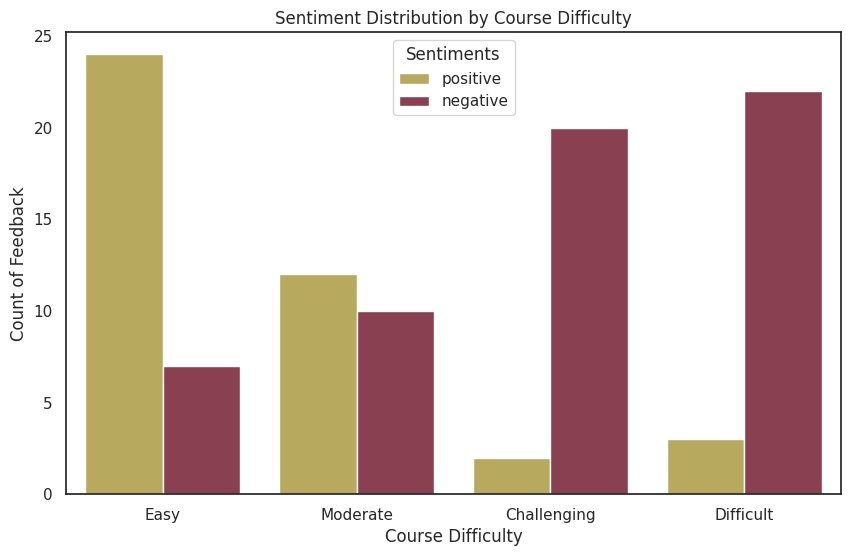

In [ ]:
# Sentiment Distribution by Course Difficulty
plt.figure(figsize=(10, 6))
# hue_order = ['positive', 'neutral', 'negative']
hue_order = ['positive', 'negative']
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Difficulty', hue='Sentiments', hue_order=hue_order, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Course Difficulty')
plt.show()

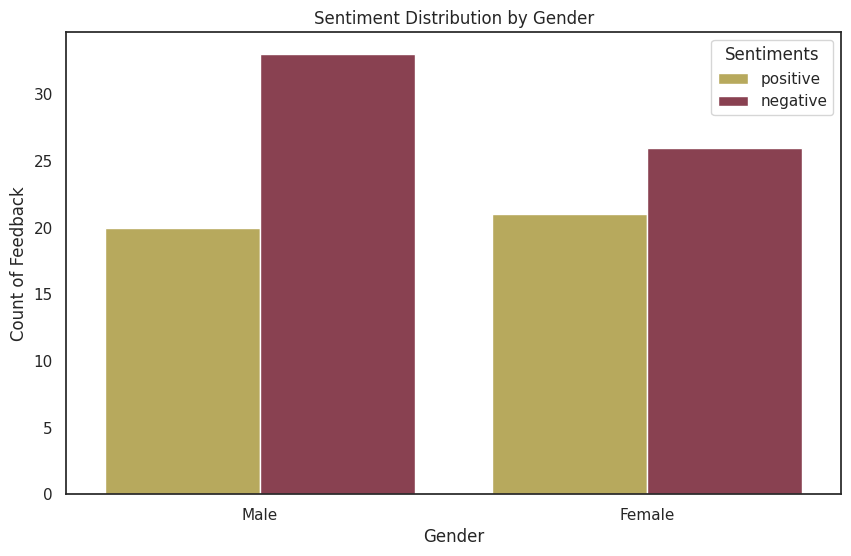

In [ ]:
# Sentiment Distribution by Gender
plt.figure(figsize=(10, 6))
# hue_order = ['positive', 'neutral', 'negative']
hue_order = ['positive', 'negative']
sns.countplot(data=df, x='Gender', hue='Sentiments', hue_order=hue_order)
plt.xlabel('Gender')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Gender')
plt.show()

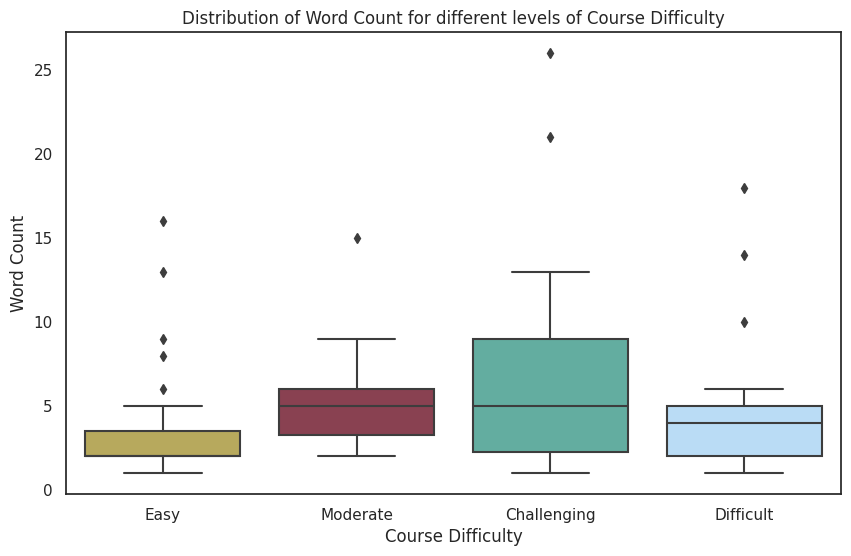

In [ ]:
# Word Count distribution by course difficulty
plt.figure(figsize=(10, 6))
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.boxplot(data=df, x='Course Difficulty', y='Word_Count', order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Word Count')
plt.title('Distribution of Word Count for different levels of Course Difficulty')
plt.show()

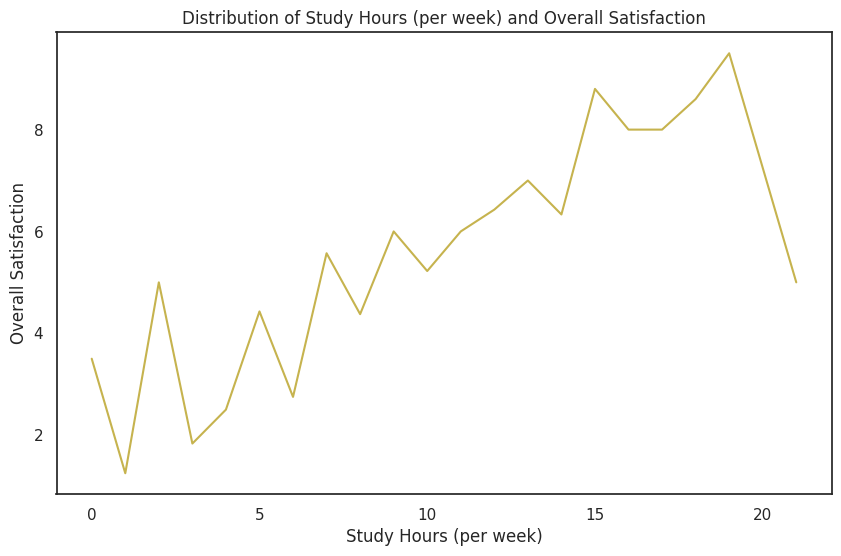

In [ ]:
# Distribution of Study Hours (per week) and Overall Satisfaction
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Study Hours (per week)', y='Overall Satisfaction', ci=None)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Overall Satisfaction')
plt.title('Distribution of Study Hours (per week) and Overall Satisfaction')
plt.show()

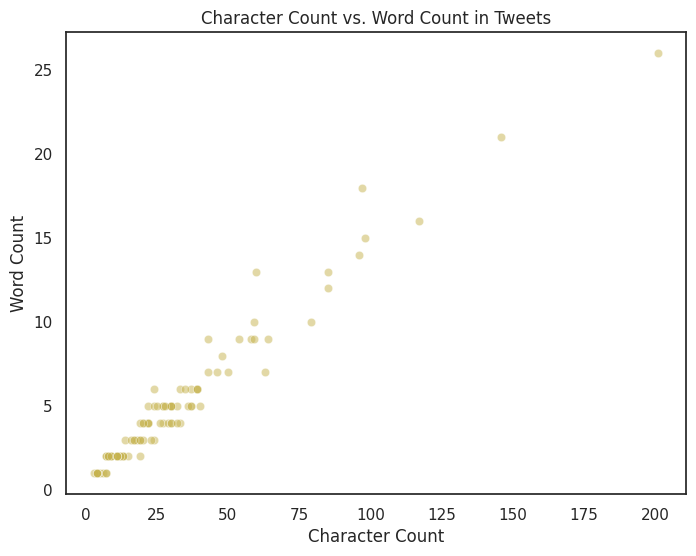

In [ ]:
# scatter plot of character count vs. word count
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Char_Count'], y=df['Word_Count'], alpha=0.5, color= color)  # Replace 'blue' with your desired color
plt.xlabel('Character Count')
plt.ylabel('Word Count')
plt.title('Character Count vs. Word Count in Tweets')
plt.show()


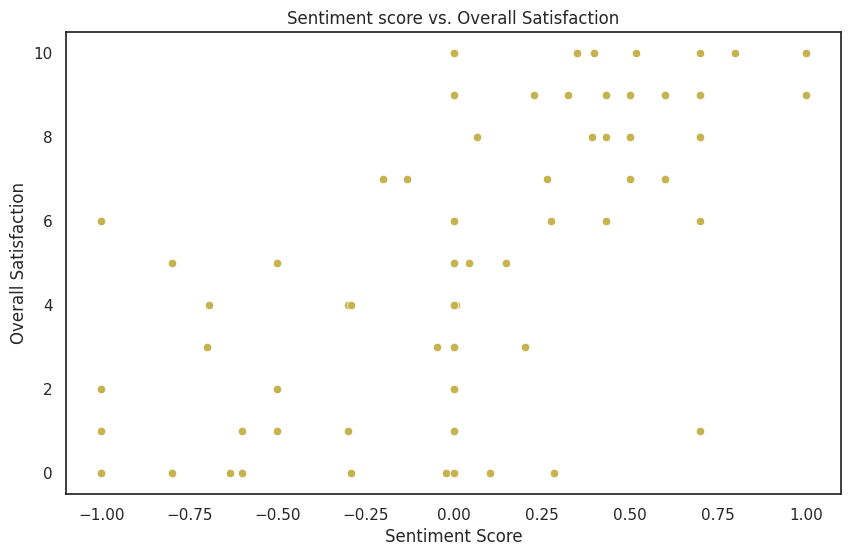

In [ ]:
# Sentiment vs. Overall Satisfaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sentiment_Scores', y='Overall Satisfaction', data=df)
plt.xlabel('Sentiment Score')
plt.ylabel('Overall Satisfaction')
plt.title('Sentiment score vs. Overall Satisfaction')
# plt.xticks(np.arange(-1, 1.1, 0.5))
# plt.yticks(np.arange(0, 11))
plt.show()

<Figure size 1000x600 with 0 Axes>

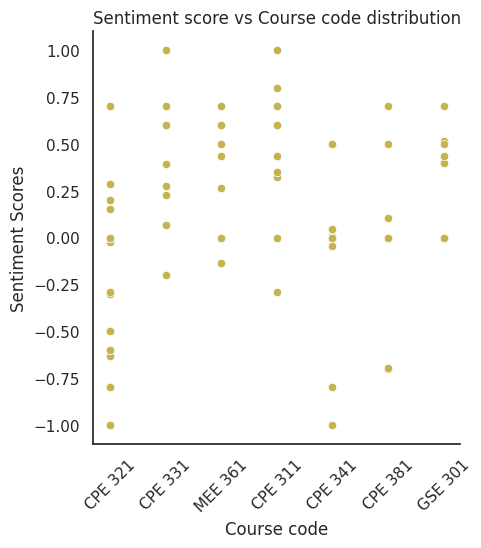

In [ ]:
# Sentiment score Distribution by Course code
plt.figure(figsize=(10, 6))
sns.relplot(data=df, x='Course Code',y = 'Sentiment_Scores', kind='scatter')
plt.xlabel('Course code')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment score vs Course code distribution')
plt.xticks(rotation=45)
plt.show();

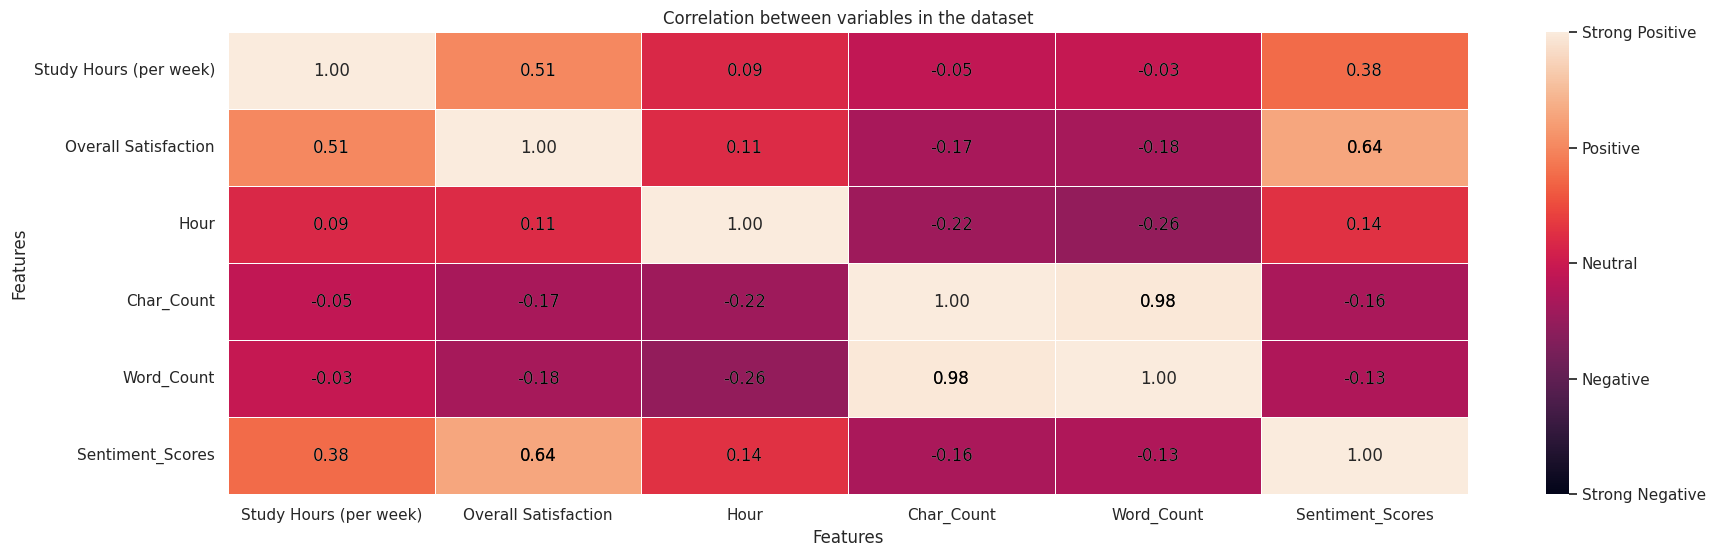

In [ ]:
# correlation matrix of numerical variables in the data
correlation_matrix = df.corr()

plt.figure(figsize=[20, 6])
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between variables in the dataset')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

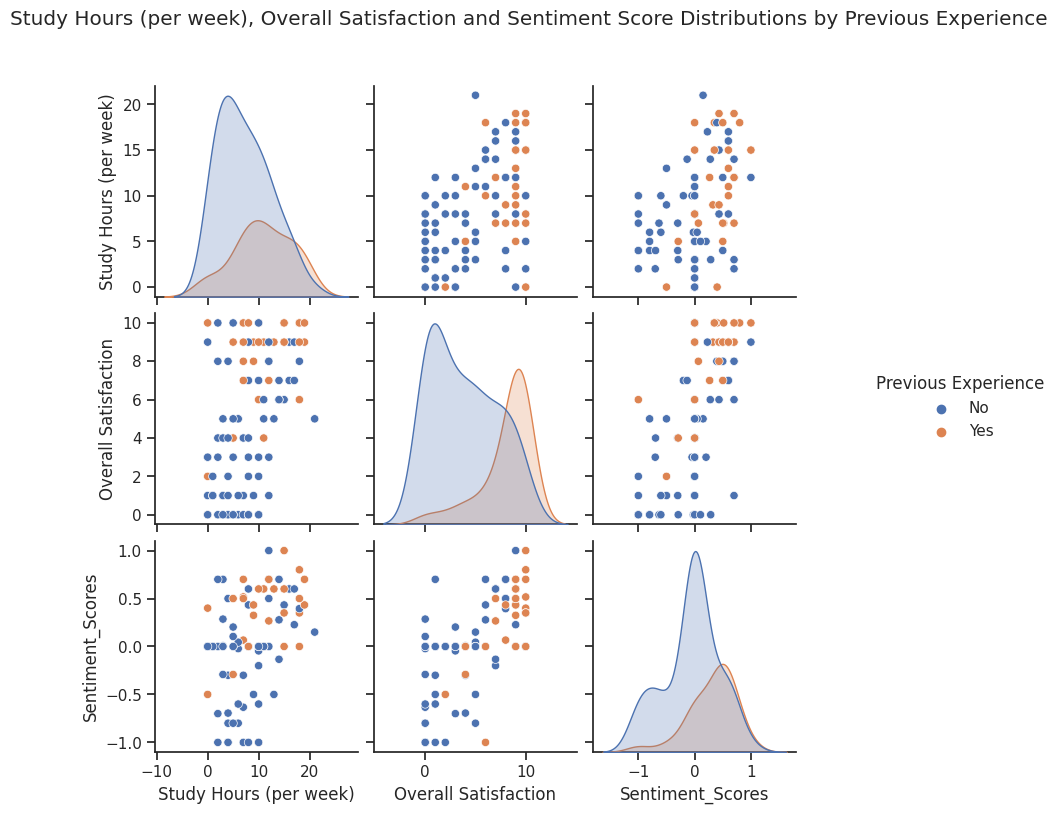

In [ ]:
sns.set(style='ticks')
sns.pairplot(data=df, vars=['Study Hours (per week)', 'Overall Satisfaction',
                            'Sentiment_Scores'], hue='Previous Experience', markers='o')
plt.suptitle('Study Hours (per week), Overall Satisfaction and Sentiment Score Distributions by Previous Experience',
             y=1.08)
plt.show();

# **Machine Learning Model**

We build a ML model for predicting sentiment labels.

In [ ]:
X = df['Processed_Feedback']
y = df['Sentiments']

print(len(X), ',', len(y))

100 , 100


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('Encoded Target Labels:')
print(y_encoded, '\n')

# get mapping for each label
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label Mappings:')
print(le_name_mapping)

Encoded Target Labels:
[1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1
 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1] 

Label Mappings:
{'negative': 0, 'positive': 1}


In [ ]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80,) (80,)
(20,) (20,)


**XGBoost Classifier**

In [ ]:
# Using random train and test subsets

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
])

# Create a model
model = xgb.XGBClassifier(
    eta=0.01,
    max_depth=7,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss',
)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model),
])

# Fit the pipeline to the train data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = pipeline.predict(X_test)

# Calculate the accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Calculate the recall score
recall_xgb = recall_score(y_test, y_pred_xgb)

# Calculate the precision score
precision_xgb = precision_score(y_test, y_pred_xgb)

# Calculate the f1-score
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print the results
print('Accuracy score: {:.3f} %'.format(accuracy_xgb * 100))
print('Recall score: {:.3f}'.format(recall_xgb))
print('Precision score: {:.3f}'.format(precision_xgb))
print('F1-score: {:.3f}'.format(f1_xgb))

Accuracy score: 70.000 %
Recall score: 0.250
Precision score: 1.000
F1-score: 0.400


In [ ]:
# using cross validation techniques

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
])

# Model
model_cv = xgb.XGBClassifier(
    eta=0.01,
    max_depth=10,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss',
)


# Pipeline
pipeline_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_cv),
])

kf = KFold(n_splits=10, shuffle=True, random_state=0)
cv_scores = cross_val_score(pipeline_cv, X, y_encoded, cv=kf)
mean_cv_score = cv_scores.mean()
print('Cross-validation accuracy score: {:.3f} %'.format(mean_cv_score*100))

Cross-validation accuracy score: 73.000 %


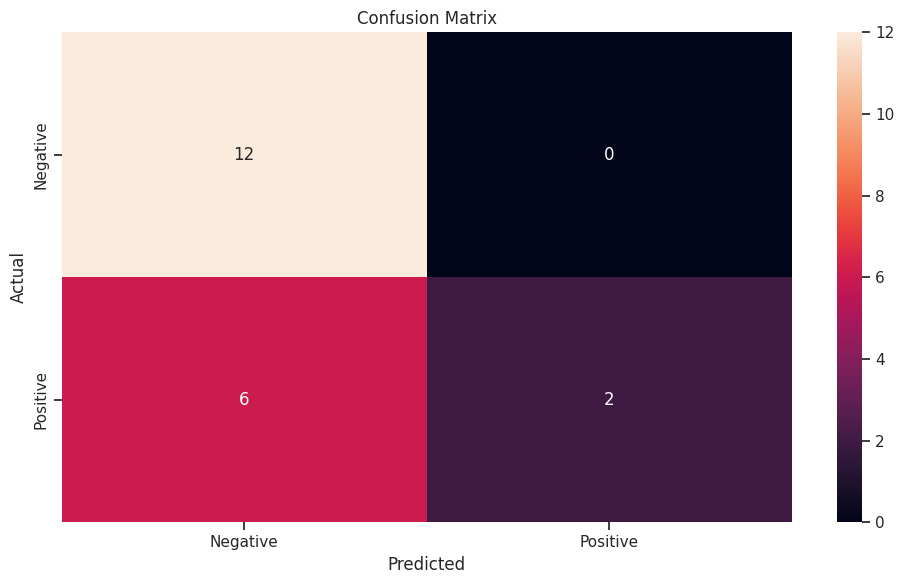

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative',  'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Support Vector Machine**

In [ ]:
# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

# Model (SVM Classifier)
svm_model = SVC()

# Pipeline
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svm_model),
])

pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)

# Calculate the accuracy score
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Calculate the recall score
recall_svm = recall_score(y_test, y_pred_svm)

# Calculate the precision score
precision_svm = precision_score(y_test, y_pred_svm)

# Calculate the f1-score
f1_svm = f1_score(y_test, y_pred_svm)

# Print the results
print('Accuracy score: {:.3f} %'.format(accuracy_svm * 100))
print('Recall score: {:.3f}'.format(recall_svm))
print('Precision score: {:.3f}'.format(precision_svm))
print('F1-score: {:.3f}'.format(f1_svm))

Accuracy score: 70.000 %
Recall score: 0.250
Precision score: 1.000
F1-score: 0.400


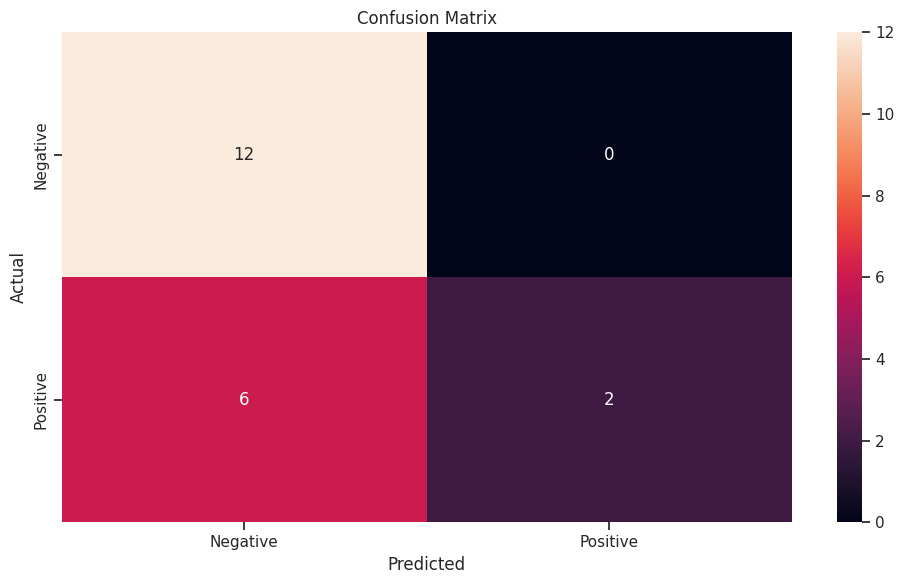

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative',  'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Random Forest Classifier**



In [ ]:

from sklearn.ensemble import RandomForestClassifier

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

random_forest = RandomForestClassifier()

# Pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', random_forest),
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# Calculate the accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Calculate the recall score
recall_rf = recall_score(y_test, y_pred_rf)

# Calculate the precision score
precision_rf = precision_score(y_test, y_pred_rf)

# Calculate the f1-score
f1_rf = f1_score(y_test, y_pred_rf)

# Print the results
print('Accuracy score: {:.3f} %'.format(accuracy_rf * 100))
print('Recall score: {:.3f}'.format(recall_rf))
print('Precision score: {:.3f}'.format(precision_rf))
print('F1-score: {:.3f}'.format(f1_rf))

Accuracy score: 75.000 %
Recall score: 0.375
Precision score: 1.000
F1-score: 0.545


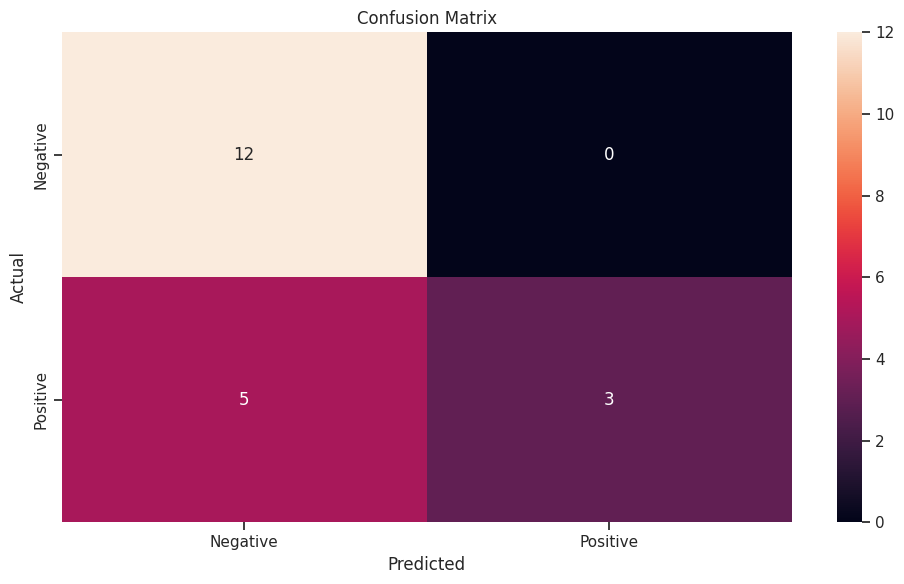

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative',  'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

naive_bayes = MultinomialNB()

# Pipeline
pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', naive_bayes),
])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

# Calculate the accuracy score
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# Calculate the recall score
recall_nb = recall_score(y_test, y_pred_nb)

# Calculate the precision score
precision_nb = precision_score(y_test, y_pred_nb)

# Calculate the f1-score
f1_nb = f1_score(y_test, y_pred_nb)

# Print the results
print('Accuracy score: {:.3f} %'.format(accuracy_nb * 100))
print('Recall score: {:.3f}'.format(recall_nb))
print('Precision score: {:.3f}'.format(precision_nb))
print('F1-score: {:.3f}'.format(f1_nb))

Accuracy score: 80.000 %
Recall score: 0.500
Precision score: 1.000
F1-score: 0.667


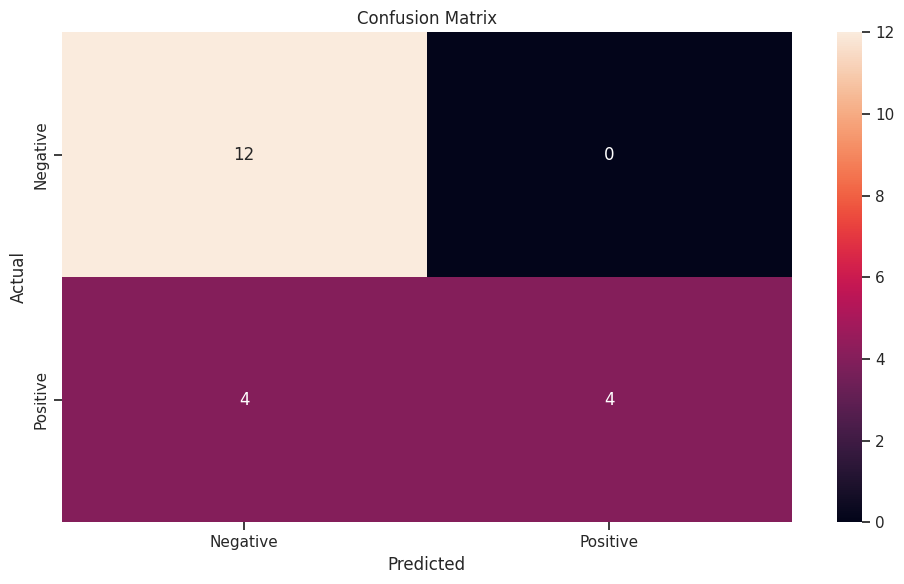

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative',  'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Comparison of Accuracy Scores of all Models used.**

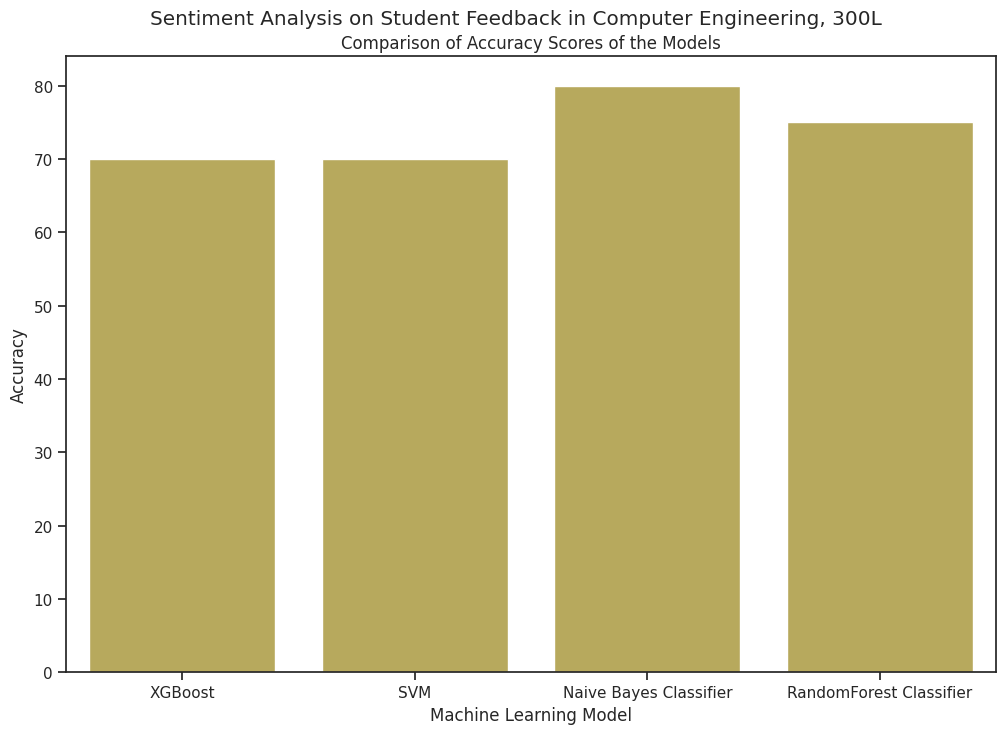

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=['XGBoost', 'SVM', 'Naive Bayes Classifier', 'RandomForest Classifier'],
            y=[accuracy_xgb*100, accuracy_svm*100, accuracy_nb*100, accuracy_rf*100],
            color=color)
plt.xlabel('Machine Learning Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Scores of the Models')
plt.suptitle('Sentiment Analysis on Student Feedback in Computer Engineering, 300L', y=0.939)
plt.show()


In [ ]:
print('Label Mappings:')
print(le_name_mapping)

pipeline.fit(X, y_encoded)
sentiment_categories = {0: 'negative', 1: 'positive'}
print(sentiment_categories)

Label Mappings:
{'negative': 0, 'positive': 1}
{0: 'negative', 1: 'positive'}


In [ ]:
new_examples = [
    "I swear, I hate the professor with his crazy course",
    "Adebayo go just dy stress person life mtcheww",
    "Practicals are surreal in 381",
    "Why we still dy get 8'o clock class? lol"
    "Una don craze for this department",
    "raqibcodes sef na low-key scholar",
    "I love coding a lot",
    "good"
]

In [ ]:

!pip install transformers
!pip install absa



In [ ]:
# XGBoost

predicted_sentiments = pipeline.predict(preprocess_text(example) for example in new_examples)
predicted_sentiment_labels = [sentiment_categories[sentiment] for sentiment in predicted_sentiments]

print("Predicted Sentiments:", predicted_sentiment_labels)

Predicted Sentiments: ['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive']


In [ ]:
# SVM

predicted_sentiments = pipeline_svm.predict(preprocess_text(example) for example in new_examples)
predicted_sentiment_labels = [sentiment_categories[sentiment] for sentiment in predicted_sentiments]

print("Predicted Sentiments:", predicted_sentiment_labels)

Predicted Sentiments: ['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive']


In [ ]:
# NB

predicted_sentiments = pipeline_nb.predict(preprocess_text(example) for example in new_examples)
predicted_sentiment_labels = [sentiment_categories[sentiment] for sentiment in predicted_sentiments]

print("Predicted Sentiments:", predicted_sentiment_labels)

Predicted Sentiments: ['negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive']


In [ ]:
# export data to csv to perform further text classification with BERT and KerasNLP
df.to_csv('exported_sentiments.csv', index=False)

Text Classification With BERT and KerasNLP

Now since I am done building the sentiment analysis model using different algorithms, I will make use of BERT, a popular Masked Language Model which is bidirectional (it has access to the words left and right) to build a the text classification model and also KerasNLP, which provides a simple Keras API for training and finetuning NLP models to classify the sentiments.

In [ ]:
!pip install keras-nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.1/590.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 58.0 MB/s eta 0:00:00


In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.2 MB/s eta 0:00:00


In [ ]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import zipfile
import os
import string
import tensorflow as tf
from tensorflow import keras
import keras_nlp
from transformers import BertTokenizer, TFBertForSequenceClassification
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend


In [ ]:
# load the exported data
df1 = pd.read_csv('/content/exported_sentiments.csv')
# encode the target labels
df1['Sentiments'] = df1['Sentiments'].replace({
    'negative': 0,
    'positive': 1
})
df1['Sentiments'].value_counts()

0    59
1    41
Name: Sentiments, dtype: int64

In [ ]:
X = df1['Feedback']
y = df1['Sentiments']
print(y)
print()
X.to_frame()


0     1
1     1
2     0
3     0
4     0
     ..
95    1
96    0
97    0
98    1
99    1
Name: Sentiments, Length: 100, dtype: int64



,Feedback
0,"The man is too fast in his teaching,he clearly..."
1,The class is dry but he really puts in efforts
2,The course is shit and it's a threat to my bra...
3,"He no try at all, didn’t teach well."
4,Ogbeni you sef know as e dae go
...,...
95,easy and no wahala
96,terrible way of teaching with the I-dont-care ...
97,do not like coding
98,this practical is hard on top 1 unit course haba


In [ ]:
# Text Preprocessing of the texts column using NLTK
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r'\b[0-9]+\b\s*', '', text)
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

X_preprocessed = [preprocess_text(text) for text in X]

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pd.Series(X_preprocessed), y, test_size=0.25)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(75,) (75,)
(25,) (25,)


In [ ]:
# Convert labels to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2, dtype='float32')
# load the pretrained BERT model that has been finetuned for sentiment analysis

model_name = "bert_tiny_en_uncased_sst2"
classifier = keras_nlp.models.BertClassifier.from_preset(
    model_name,
    num_classes=2,
    load_weights = True,
    activation='sigmoid' # for the binary classification task
)

17596448/17596448 [==============================] - 0s 0us/step


In [ ]:
classifier.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    jit_compile=True,
     metrics=["accuracy"],
)
# Access backbone programatically (e.g., to change `trainable`).
classifier.backbone.trainable = False
# Fit again.
classifier.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), batch_size=64)

2/2 [==============================] - 91s 45s/step - loss: 0.4550 - accuracy: 0.7867 - val_loss: 0.7033 - val_accuracy: 0.6800


In [ ]:
# evaluate the model on the testing data
classifier.evaluate(X_test, y_test,batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.7033 - accuracy: 0.6800


[0.7033333778381348, 0.6800000071525574]

In [ ]:
# checking the model to see performance on new samples
sentiment_categories = ["negative", "positive"]

new_examples = list(df1['Feedback'].sample(10))

scores = classifier.predict([preprocess_text(example) for example in new_examples])

for i, score in enumerate(scores):
    print(f"{new_examples[i]}:➡ {sentiment_categories[np.argmax(score)]} with a { (100 * np.max(score)).round(2) } percent confidence.")
    print()

1/1 [==============================] - 3s 3s/step
fair play:➡ positive with a 58.03 percent confidence.

awesome:➡ positive with a 92.09 percent confidence.

nice course :➡ positive with a 90.83 percent confidence.

thank God for my coding skills  bruh:➡ negative with a 65.63 percent confidence.

Course is well thought:➡ positive with a 75.0 percent confidence.

love to code:➡ positive with a 59.97 percent confidence.

Na me dey make the class funny pass even though the man go do him best make am dry.:➡ positive with a 55.5 percent confidence.

The course is not well taught. Worst still, we are writing codes on paper for exams.:➡ negative with a 93.68 percent confidence.

I hate this course plus the man:➡ negative with a 93.6 percent confidence.

The teaching mode and environment is top tier but the course itself requires deep thinking and reasoning especially questions seen in exam so the little learned during classes is certainly not enough to solve the problems, especially if you do

In [ ]:
#Improving model accuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# During model fitting
classifier.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=32, callbacks=[lr_scheduler])


3/3 [==============================] - 20s 3s/step - loss: 0.2663 - accuracy: 0.8800 - val_loss: 0.5391 - val_accuracy: 0.7200 - lr: 0.0010


In [ ]:
# evaluate the model on the testing data
classifier.evaluate(X_test, y_test,batch_size=32)

1/1 [==============================] - 2s 2s/step - loss: 0.5391 - accuracy: 0.7200


[0.5391245484352112, 0.7200000286102295]

In [ ]:
# checking the model to see performance on new samples
sentiment_categories = ["negative", "positive"]

new_examples = list(df1['Feedback'].sample(10))

scores = classifier.predict([preprocess_text(example) for example in new_examples])

for i, score in enumerate(scores):
    print(f"{new_examples[i]}:➡ {sentiment_categories[np.argmax(score)]} with a { (100 * np.max(score)).round(2) } percent confidence.")
    print()

1/1 [==============================] - 2s 2s/step
The outline of the course is difficult and lecturer is bad:➡ negative with a 94.41 percent confidence.

course should  not be difficult but lecturer messed it up:➡ negative with a 91.97 percent confidence.

nice:➡ positive with a 94.99 percent confidence.

The teaching mode is okay as the lecturer do revision of what's being taught from time to time.:➡ positive with a 91.65 percent confidence.

The lecturer is good and his course is also good:➡ positive with a 95.04 percent confidence.

GSE was very okay:➡ positive with a 93.13 percent confidence.

LA didnt start well but Engineer Adeboye did well but in the end, the course was tricky:➡ positive with a 86.1 percent confidence.

Nice teaching from scientist:➡ positive with a 95.02 percent confidence.

thank God for my coding skills  bruh:➡ positive with a 73.3 percent confidence.

The course is actually well detailed in the material the lecturer uses. The lecturer is also cool-headed and